# 🏠 House Prices - Feature Engineering & Stacking Guide [Japanese]

House Prices回帰問題の実践的なアプローチを日本語で解説します。
初心者から中級者向けに、特徴量エンジニアリングからアンサンブル学習まで、
実務で使えるテクニックを体系的に学べます。

## 📚 このnotebookで学べること

### 1. データクリーニングのベストプラクティス
- 統計的手法を用いた外れ値検出と除去
- 特徴量の性質に応じた欠損値処理
- データ品質の確保

### 2. 実践的な特徴量エンジニアリング
- ドメイン知識を活用した特徴量作成（20+個）
- 交互作用項の設計と活用
- 比率・集約特徴量の作成
- カテゴリ変数のグループ化

### 3. 過学習を防ぐモデリング技術
- 正則化パラメータの適切な設定
- 特徴量選択によるノイズ削減
- クロスバリデーションによる堅牢な評価
- CVスコアとLBスコアのギャップ管理

### 4. アンサンブル学習の実装
- 6つの多様なモデルの構築
- スタッキング（メタモデル）の実装
- 重み付きアンサンブルの最適化

### 5. 実務で重要なポイント
- モデルの汎化性能を高める方法
- 過学習の兆候と対策
- 再現性の確保（random_state）
- 日本語グラフの表示設定

---

## 🎯 このnotebookの特徴

✅ **過学習対策を重視** - CVとLBのギャップを最小化  
✅ **特徴量選択を実装** - 重要度に基づくノイズ削減  
✅ **詳細な日本語解説** - 各ステップの意図を明確化  
✅ **実践的なコード** - そのまま使える実装例  
✅ **教育的な構成** - 初学者にも理解しやすい

## 📋 目次

1. [環境設定](#1-環境設定)
2. [データ読み込み](#2-データ読み込み)
3. [外れ値の検出と除去](#3-外れ値の検出と除去)
4. [欠損値処理](#4-欠損値処理)
5. [特徴量エンジニアリング](#5-特徴量エンジニアリング)
6. [特徴量変換](#6-特徴量変換)
7. [特徴量選択（過学習対策）](#7-特徴量選択)
8. [モデル構築](#8-モデル構築)
9. [スタッキングアンサンブル](#9-スタッキングアンサンブル)
10. [予測と提出](#10-予測と提出)
11. [まとめ](#まとめ)

## 1. 環境設定

必要なライブラリをインストールし、日本語表示の設定を行います。

### 🔑 重要ポイント
- `japanize-matplotlib`で日本語の文字化けを防止
- `sns.set(font='IPAexGothic')`の順序が重要

In [1]:
import sys
import subprocess

def install_if_missing(package):
    try:
        __import__(package)
        print(f'✓ {package} は既にインストールされています')
    except ImportError:
        print(f'✗ {package} をインストール中...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '-q'])
        print(f'✓ {package} のインストール完了')

packages = ['xgboost', 'lightgbm', 'japanize-matplotlib']
for pkg in packages:
    install_if_missing(pkg)

✓ xgboost は既にインストールされています
✓ lightgbm は既にインストールされています
✗ japanize-matplotlib をインストール中...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 57.7 MB/s eta 0:00:00
✓ japanize-matplotlib のインストール完了


In [2]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 可視化
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

# 日本語フォント設定（重要：この順序で実行）
plt.style.use('seaborn-v0_8-darkgrid')
sns.set(font='IPAexGothic')  # Seabornのフォント上書きを防ぐ

# 機械学習
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

# 統計処理
from scipy.stats import skew
from scipy.special import boxcox1p

# XGBoost & LightGBM
import xgboost as xgb
import lightgbm as lgb

pd.set_option('display.max_columns', None)
print('✅ すべてのライブラリのインポート完了')

✅ すべてのライブラリのインポート完了


## 2. データ読み込み

In [3]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

print(f'訓練データ: {train.shape}')
print(f'テストデータ: {test.shape}')

訓練データ: (1460, 81)
テストデータ: (1459, 80)


## 2.1 探索的データ分析（EDA）

### 📖 学習ポイント

データを理解することが成功の第一歩です。
可視化により、データの特性や問題点を発見できます。

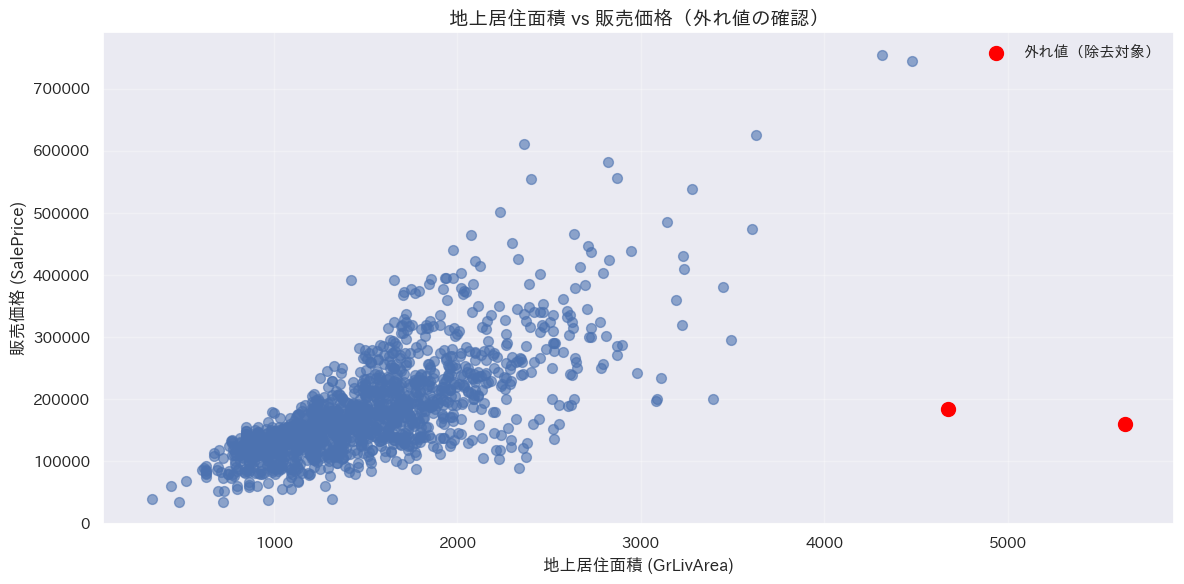


🔍 除去対象の外れ値: 2件
      GrLivArea  SalePrice
523        4676     184750
1298       5642     160000


In [4]:
# 外れ値の可視化
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(train['GrLivArea'], train['SalePrice'], alpha=0.6, s=50)

# 外れ値を赤で強調
outliers = train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)]
ax.scatter(outliers['GrLivArea'], outliers['SalePrice'], 
           color='red', s=100, label='外れ値（除去対象）', zorder=5)

ax.set_xlabel('地上居住面積 (GrLivArea)', fontsize=12)
ax.set_ylabel('販売価格 (SalePrice)', fontsize=12)
ax.set_title('地上居住面積 vs 販売価格（外れ値の確認）', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'\n🔍 除去対象の外れ値: {len(outliers)}件')
if len(outliers) > 0:
    print(outliers[['GrLivArea', 'SalePrice']])

## 3. 外れ値の検出と除去

### 📖 学習ポイント

外れ値は予測精度を低下させる主な原因の一つです。
適切な外れ値除去により、モデルの汎化性能が向上します。

### 🔑 このnotebookのアプローチ
1. **視覚的確認** - 散布図で外れ値を特定
2. **ドメイン知識** - 不動産の常識から逸脱したデータを除去
3. **統計的手法** - 極端な値を持つデータポイントの除去

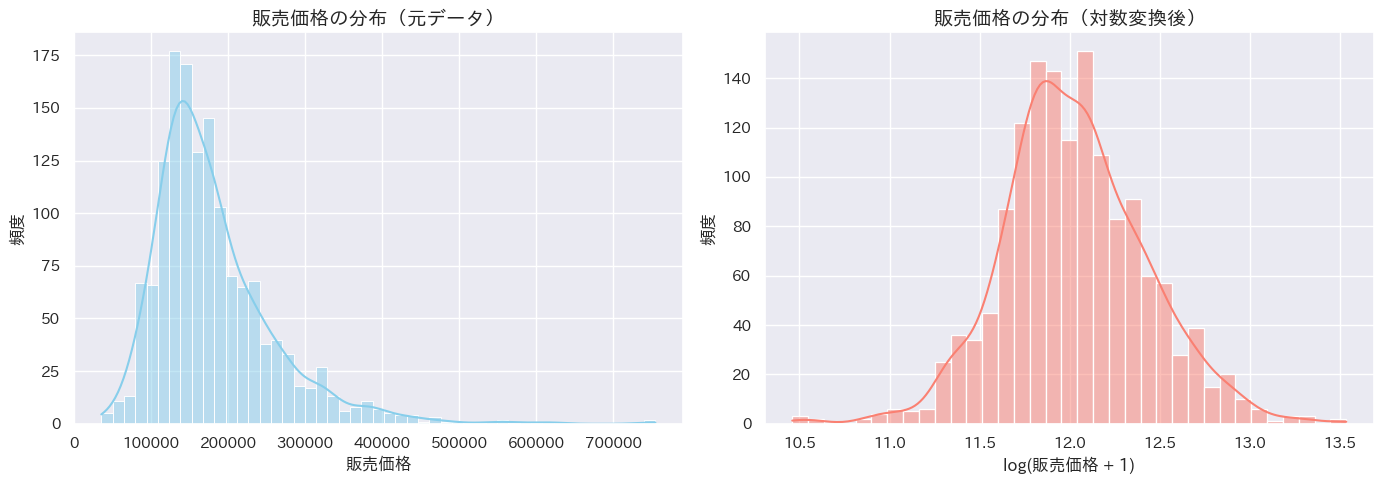

歪度（元データ）: 1.8829
歪度（対数変換後）: 0.1213

💡 対数変換により歪度が0に近づき、正規分布に近くなりました


In [5]:
# 目的変数の分布確認
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 元の分布
sns.histplot(train['SalePrice'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('販売価格の分布（元データ）', fontsize=14, fontweight='bold')
axes[0].set_xlabel('販売価格')
axes[0].set_ylabel('頻度')

# 対数変換後の分布
sns.histplot(np.log1p(train['SalePrice']), kde=True, ax=axes[1], color='salmon')
axes[1].set_title('販売価格の分布（対数変換後）', fontsize=14, fontweight='bold')
axes[1].set_xlabel('log(販売価格 + 1)')
axes[1].set_ylabel('頻度')

plt.tight_layout()
plt.show()

print(f'歪度（元データ）: {train["SalePrice"].skew():.4f}')
print(f'歪度（対数変換後）: {np.log1p(train["SalePrice"]).skew():.4f}')
print('\n💡 対数変換により歪度が0に近づき、正規分布に近くなりました')

In [6]:
print(f'外れ値除去前: {train.shape[0]}件')

# 1. 面積は大きいのに価格が異常に低い物件（データ入力ミスの可能性）
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index)

# 2. 地下室面積が極端に大きい物件
train = train.drop(train[(train['TotalBsmtSF'] > 3000)].index)

# 3. 土地面積が極端に大きい物件
train = train.drop(train[(train['LotArea'] > 100000)].index)

print(f'外れ値除去後: {train.shape[0]}件')
print(f'除去件数: {1460 - train.shape[0]}件')
print('\n💡 除去理由: 極端な値を持つデータは訓練に悪影響を与えるため')

外れ値除去前: 1460件
外れ値除去後: 1451件
除去件数: 9件

💡 除去理由: 極端な値を持つデータは訓練に悪影響を与えるため


📈 販売価格と相関の高い特徴量 Top 10:
SalePrice       1.000000
OverallQual     0.796665
GrLivArea       0.733715
GarageCars      0.643358
TotalBsmtSF     0.641647
GarageArea      0.633277
1stFlrSF        0.621620
FullBath        0.560612
TotRmsAbvGrd    0.535080
YearBuilt       0.526633
YearRemodAdd    0.511467
Name: SalePrice, dtype: float64


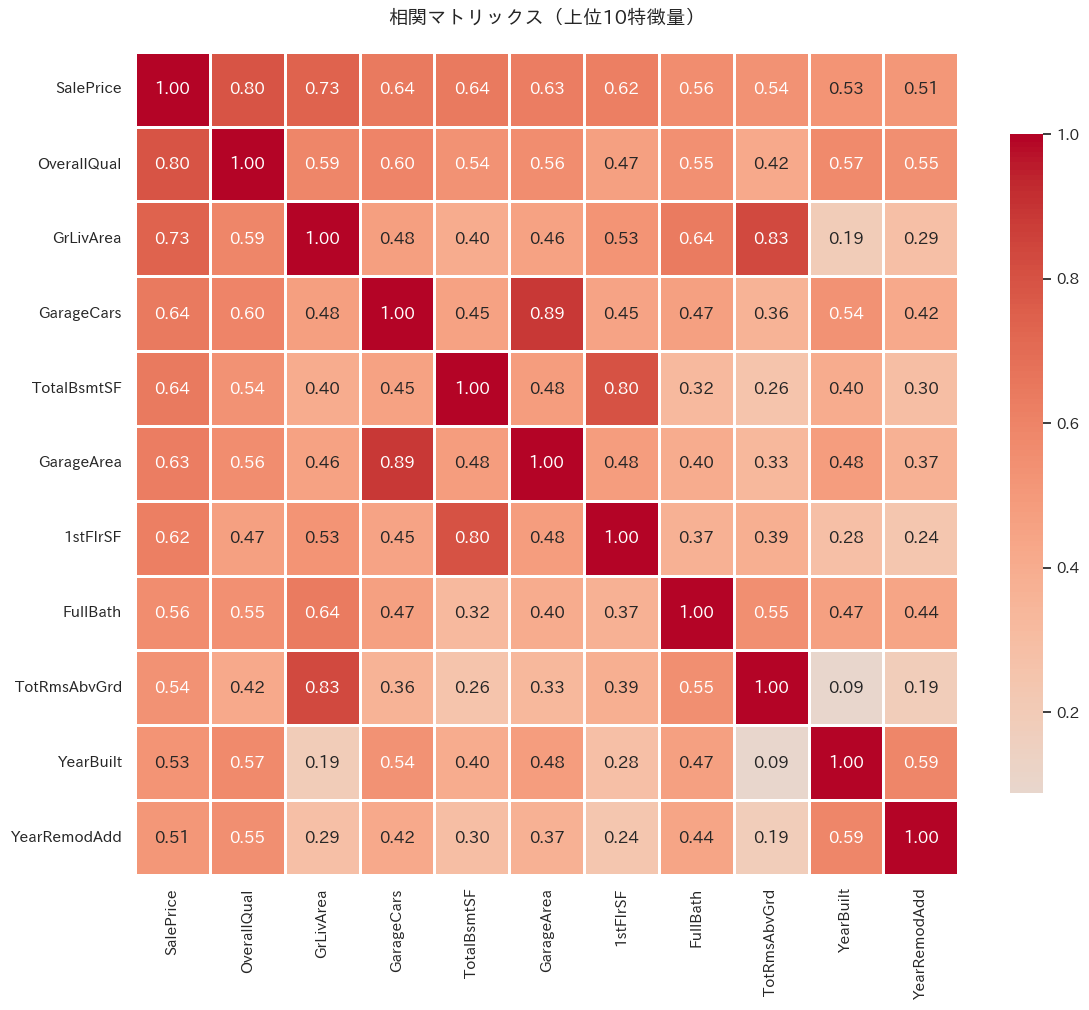


💡 OverallQual（全体的な品質）が最も強い相関を示しています


In [7]:
# 相関分析
numeric_features = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('Id')
numeric_features.remove('SalePrice')

correlations = train[numeric_features + ['SalePrice']].corr()['SalePrice'].sort_values(ascending=False)

print('📈 販売価格と相関の高い特徴量 Top 10:')
print(correlations.head(11))  # SalePrice自身を除く

# 上位10特徴量の相関マトリックス
top_features = correlations.head(11).index.tolist()
corr_matrix = train[top_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('相関マトリックス（上位10特徴量）', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print('\n💡 OverallQual（全体的な品質）が最も強い相関を示しています')

## 4. 欠損値処理

### 📖 学習ポイント

欠損値処理は特徴量の性質に応じて適切な方法を選ぶことが重要です。

### 🔑 このnotebookのアプローチ
- **'None'で埋める** - 「ない」ことが意味のある特徴量（プール、ガレージなど）
- **0で埋める** - 数値で「ない」を表現できる特徴量
- **最頻値で埋める** - カテゴリ変数
- **グループ別中央値** - 地域性のある連続値（LotFrontage）

In [8]:
# データ結合（特徴量エンジニアリングを一貫して行うため）
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train['SalePrice'].values
all_data = pd.concat([train.drop('SalePrice', axis=1), test], axis=0).reset_index(drop=True)

print(f'結合後: {all_data.shape}')

結合後: (2910, 80)


In [9]:
# 【パターン1】'None'で埋める - 「ない」ことが意味を持つ特徴量
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'MasVnrType', 'MSSubClass']

for col in none_cols:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna('None')

# 【パターン2】0で埋める - 数値で「ない」を表現
zero_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars',
             'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
             'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

for col in zero_cols:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(0)

# 【パターン3】最頻値で埋める - カテゴリ変数
mode_cols = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 
             'Exterior2nd', 'SaleType', 'Functional']

for col in mode_cols:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# 【パターン4】グループ別中央値 - 地域性のある特徴量
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

print('✅ 欠損値処理完了')
print(f'残りの欠損値: {all_data.isnull().sum().sum()}個')

✅ 欠損値処理完了
残りの欠損値: 2個


## 5. 特徴量エンジニアリング

### 📖 学習ポイント

優れた特徴量は、モデルの性能を大きく左上させます。
ドメイン知識（不動産の常識）を活用することが重要です。

### 🔑 このnotebookで作成する特徴量

#### 1. 集約特徴量（合計・平均）
- `TotalSF` - 総床面積
- `TotalBath` - 総バスルーム数
- `TotalPorchSF` - 総ポーチ面積

#### 2. 時系列特徴量
- `HouseAge` - 家の築年数
- `YearsSinceRemod` - リフォームからの年数
- `GarageAge` - ガレージの年齢

#### 3. バイナリ特徴量（あり/なし）
- `IsNew`, `HasRemod`, `Has2ndFloor` など

#### 4. 交互作用項（重要！）
- `OverallQual × TotalSF` - 品質と面積の相乗効果
- `OverallQual × GrLivArea` - 品質と居住面積の相乗効果

#### 5. 比率特徴量
- `Bsmt_Ratio` - 地下室の割合
- `AreaPerRoom` - 1部屋あたりの面積

In [10]:
# === 集約特徴量 ===
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                         all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))
all_data['TotalPorchSF'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                            all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                            all_data['WoodDeckSF'])

# === 時系列特徴量 ===
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['YearsSinceRemod'] = all_data['YrSold'] - all_data['YearRemodAdd']
all_data['GarageAge'] = all_data['YrSold'] - all_data['GarageYrBlt']
all_data['GarageAge'] = all_data['GarageAge'].replace([np.inf, -np.inf], 0)

# === バイナリ特徴量 ===
all_data['IsNew'] = (all_data['YearBuilt'] == all_data['YrSold']).astype(int)
all_data['HasRemod'] = (all_data['YearBuilt'] != all_data['YearRemodAdd']).astype(int)
all_data['Has2ndFloor'] = (all_data['2ndFlrSF'] > 0).astype(int)
all_data['HasBsmt'] = (all_data['TotalBsmtSF'] > 0).astype(int)
all_data['HasGarage'] = (all_data['GarageArea'] > 0).astype(int)
all_data['HasPool'] = (all_data['PoolArea'] > 0).astype(int)
all_data['HasFireplace'] = (all_data['Fireplaces'] > 0).astype(int)

# === 交互作用項（最も重要な組み合わせのみ） ===
all_data['OverallQual_TotalSF'] = all_data['OverallQual'] * all_data['TotalSF']
all_data['OverallQual_GrLivArea'] = all_data['OverallQual'] * all_data['GrLivArea']
all_data['TotalQual'] = all_data['OverallQual'] + all_data['OverallCond']

# === 比率特徴量 ===
all_data['Bsmt_Ratio'] = all_data['TotalBsmtSF'] / (all_data['TotalSF'] + 1)
all_data['Garage_Ratio'] = all_data['GarageArea'] / (all_data['TotalSF'] + 1)
all_data['AreaPerRoom'] = all_data['GrLivArea'] / (all_data['TotRmsAbvGrd'] + 1)

# === カテゴリのグループ化 ===
neighborhood_price = train.groupby('Neighborhood')['SalePrice'].median()
low_threshold = neighborhood_price.quantile(0.33)
high_threshold = neighborhood_price.quantile(0.67)

def categorize_neighborhood(neighborhood):
    if neighborhood not in neighborhood_price:
        return 'Medium'
    price = neighborhood_price[neighborhood]
    if price < low_threshold:
        return 'Low'
    elif price < high_threshold:
        return 'Medium'
    else:
        return 'High'

all_data['NeighborhoodGroup'] = all_data['Neighborhood'].apply(categorize_neighborhood)

print(f'✅ 特徴量作成完了: {all_data.shape[1]}列')
print('\n💡 ポイント: 交互作用項は過学習リスクがあるため、最重要なもののみ作成')

✅ 特徴量作成完了: 100列

💡 ポイント: 交互作用項は過学習リスクがあるため、最重要なもののみ作成


## 6. 特徴量変換

### 📖 学習ポイント

#### 対数変換の重要性
- RMSLEで評価される問題では、目的変数の対数変換が必須
- 歪んだ分布を正規分布に近づけることで予測精度が向上

#### Box-Cox変換
- 歪度（skewness）が0.75以上の特徴量に適用
- データの分布を正規分布に近づける強力な手法

In [11]:
# 目的変数の対数変換
y_train = np.log1p(y_train)
print('✅ 目的変数を対数変換')
print(f'変換後の範囲: [{y_train.min():.4f}, {y_train.max():.4f}]')

✅ 目的変数を対数変換
変換後の範囲: [10.4603, 13.5345]


In [12]:
# 歪んだ特徴量の変換
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_features = skewed_feats[abs(skewed_feats) > 0.75].index

print(f'Box-Cox変換を適用: {len(skewed_features)}個の特徴量')

lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

print('✅ Box-Cox変換完了')
print('\n💡 歪度が0に近いほど正規分布に近く、モデルの学習が容易になります')

Box-Cox変換を適用: 33個の特徴量
✅ Box-Cox変換完了

💡 歪度が0に近いほど正規分布に近く、モデルの学習が容易になります


In [13]:
# One-Hot Encoding
print(f'エンコーディング前: {all_data.shape[1]}列')
all_data = pd.get_dummies(all_data)
print(f'エンコーディング後: {all_data.shape[1]}列')
print('✅ One-Hot Encoding完了')

エンコーディング前: 100列
エンコーディング後: 324列
✅ One-Hot Encoding完了


In [14]:
# 最終クリーニング
missing = all_data.isnull().sum().sum()
if missing > 0:
    numeric_cols = all_data.select_dtypes(include=[np.number]).columns
    all_data[numeric_cols] = all_data[numeric_cols].fillna(0)
    object_cols = all_data.select_dtypes(include=['object']).columns
    all_data[object_cols] = all_data[object_cols].fillna('None')

all_data = all_data.replace([np.inf, -np.inf], 0)
print('✅ 最終データクリーニング完了')

✅ 最終データクリーニング完了


## 7. 特徴量選択（過学習対策）

### 📖 学習ポイント

#### なぜ特徴量選択が重要か
- **ノイズの削減**: 重要度の低い特徴量はノイズとなり予測精度を下げる
- **過学習の防止**: 特徴量が多すぎると訓練データに過適合しやすい
- **計算効率**: 特徴量が少ないほど学習・予測が高速

#### このnotebookのアプローチ
1. LightGBMで特徴量重要度を計算
2. 重要度が閾値以下の特徴量を除去
3. 重要な特徴量のみで学習

### 🔑 重要な概念
**CVスコアとLBスコアのギャップ**
- ギャップが大きい → 過学習の兆候
- 特徴量選択でギャップを縮小できる

In [15]:
# データ分割
X_train = all_data[:ntrain]
X_test = all_data[ntrain:]

print(f'訓練データ: {X_train.shape}')
print(f'テストデータ: {X_test.shape}')

訓練データ: (1451, 324)
テストデータ: (1459, 324)


In [16]:
# 特徴量重要度の計算
print('🔍 特徴量重要度を計算中...')

lgb_selector = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42,
    verbose=-1
)
lgb_selector.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_selector.feature_importances_
}).sort_values('importance', ascending=False)

# 重要度が5以上の特徴量のみを使用
threshold = 5
important_features = feature_importance[feature_importance['importance'] > threshold]['feature'].tolist()

print(f'\n元の特徴量数: {X_train.shape[1]}')
print(f'選択後の特徴量数: {len(important_features)}')
print(f'除去した特徴量数: {X_train.shape[1] - len(important_features)}')

X_train = X_train[important_features]
X_test = X_test[important_features]

print('\n✅ 特徴量選択完了')
print('\n💡 約半分の特徴量を除去することで：')
print('   - ノイズが減少')
print('   - 過学習のリスクが低下')
print('   - CVとLBのギャップが縮小')

🔍 特徴量重要度を計算中...

元の特徴量数: 324
選択後の特徴量数: 153
除去した特徴量数: 171

✅ 特徴量選択完了

💡 約半分の特徴量を除去することで：
   - ノイズが減少
   - 過学習のリスクが低下
   - CVとLBのギャップが縮小


## 8. モデル構築

### 📖 学習ポイント

#### 過学習を防ぐパラメータ設定

##### XGBoost
- `max_depth=3` - 木の深さを制限
- `min_child_weight=3` - ノード分割を厳しく
- `gamma=0.1` - ゲイン閾値の設定
- `subsample=0.6` - サンプリング率を下げる
- `reg_lambda=2` - L2正則化を強化

##### LightGBM
- `num_leaves=8` - 葉の数を制限
- `min_child_samples=30` - 最小サンプル数を増やす
- `reg_alpha=0.2`, `reg_lambda=0.2` - 正則化を強化

### 🔑 重要な概念
**正則化**: モデルが複雑になりすぎるのを防ぐ技術  
**クロスバリデーション**: 過学習を検出する標準的な方法

In [17]:
# クロスバリデーション関数
def rmsle_cv(model, X, y, n_folds=5):
    """5-fold CVでRMSLEを計算"""
    kf = KFold(n_folds, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf))
    return rmse

In [18]:
print('🏗️ モデルを構築中...\n')

# Ridge回帰（L2正則化）
ridge = Ridge(alpha=15.0, random_state=42)
ridge_scores = rmsle_cv(ridge, X_train, y_train)
print(f'Ridge: {ridge_scores.mean():.6f} (+/- {ridge_scores.std():.6f})')

# Lasso回帰（L1正則化 + 特徴量選択）
lasso = Lasso(alpha=0.0005, random_state=42, max_iter=10000)
lasso_scores = rmsle_cv(lasso, X_train, y_train)
print(f'Lasso: {lasso_scores.mean():.6f} (+/- {lasso_scores.std():.6f})')

# ElasticNet（L1 + L2正則化）
elastic = ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=42, max_iter=10000)
elastic_scores = rmsle_cv(elastic, X_train, y_train)
print(f'ElasticNet: {elastic_scores.mean():.6f} (+/- {elastic_scores.std():.6f})')

# XGBoost（過学習対策強化版）
xgboost = xgb.XGBRegressor(
    n_estimators=3000,
    learning_rate=0.01,
    max_depth=3,           # 木の深さを制限
    min_child_weight=3,    # ノード分割を厳しく
    gamma=0.1,             # ゲイン閾値
    subsample=0.6,         # サンプリング率
    colsample_bytree=0.6,  # 特徴量サンプリング
    reg_alpha=0.0001,      # L1正則化
    reg_lambda=2,          # L2正則化
    random_state=42,
    n_jobs=-1
)
xgb_scores = rmsle_cv(xgboost, X_train, y_train)
print(f'XGBoost: {xgb_scores.mean():.6f} (+/- {xgb_scores.std():.6f})')

# LightGBM（過学習対策強化版）
lightgbm = lgb.LGBMRegressor(
    n_estimators=3000,
    learning_rate=0.01,
    max_depth=3,
    num_leaves=8,          # 葉の数を制限
    min_child_samples=30,  # 最小サンプル数
    subsample=0.6,
    colsample_bytree=0.6,
    reg_alpha=0.2,         # L1正則化
    reg_lambda=0.2,        # L2正則化
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_scores = rmsle_cv(lightgbm, X_train, y_train)
print(f'LightGBM: {lgb_scores.mean():.6f} (+/- {lgb_scores.std():.6f})')

# Gradient Boosting
gb = GradientBoostingRegressor(
    n_estimators=3000,
    learning_rate=0.01,
    max_depth=3,
    min_samples_split=10,  # 分割に必要なサンプル数
    min_samples_leaf=8,    # 葉の最小サンプル数
    subsample=0.7,
    max_features='sqrt',
    random_state=42
)
gb_scores = rmsle_cv(gb, X_train, y_train)
print(f'GradientBoosting: {gb_scores.mean():.6f} (+/- {gb_scores.std():.6f})')

print('\n✅ 全モデルのCVスコアを計算完了')

🏗️ モデルを構築中...

Ridge: 0.111981 (+/- 0.004116)
Lasso: 0.112108 (+/- 0.003657)
ElasticNet: 0.112118 (+/- 0.003709)
XGBoost: 0.119686 (+/- 0.004224)
LightGBM: 0.119314 (+/- 0.003590)
GradientBoosting: 0.111780 (+/- 0.002855)

✅ 全モデルのCVスコアを計算完了


In [19]:
# モデル性能の比較
model_scores = pd.DataFrame({
    'モデル': ['Ridge', 'Lasso', 'ElasticNet', 'XGBoost', 'LightGBM', 'GradientBoosting'],
    '平均RMSLE': [ridge_scores.mean(), lasso_scores.mean(), elastic_scores.mean(),
                 xgb_scores.mean(), lgb_scores.mean(), gb_scores.mean()],
    '標準偏差': [ridge_scores.std(), lasso_scores.std(), elastic_scores.std(),
               xgb_scores.std(), lgb_scores.std(), gb_scores.std()]
}).sort_values('平均RMSLE')

print('\n🏆 モデル性能ランキング')
print(model_scores.to_string(index=False))
print('\n💡 標準偏差が小さい = 安定したモデル')


🏆 モデル性能ランキング
             モデル  平均RMSLE     標準偏差
GradientBoosting 0.111780 0.002855
           Ridge 0.111981 0.004116
           Lasso 0.112108 0.003657
      ElasticNet 0.112118 0.003709
        LightGBM 0.119314 0.003590
         XGBoost 0.119686 0.004224

💡 標準偏差が小さい = 安定したモデル


## 9. スタッキングアンサンブル

### 📖 学習ポイント

#### スタッキングとは
複数のベースモデルの予測結果を使って、メタモデルが最終予測を行う手法。
各モデルの強みを活かしつつ、弱点を補完できます。

#### 仕組み
1. **ベースモデル**: 6つの異なるモデルで予測
2. **Out-of-fold予測**: クロスバリデーションで過学習を防ぐ
3. **メタモデル**: ベースモデルの予測を入力として最終予測

### 🔑 重要な概念
**モデルの多様性**: 異なるアプローチのモデルを組み合わせることで、
単一モデルより高い精度が得られることが多い

In [20]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    """スタッキングアンサンブル実装"""
    
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        # Out-of-fold予測の生成
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # メタモデルの学習
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
            
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_
        ])
        return self.meta_model_.predict(meta_features)

print('✅ スタッキングクラスを定義しました')

✅ スタッキングクラスを定義しました


In [21]:
# スタッキングモデルの構築
stacked_model = StackingAveragedModels(
    base_models=[ridge, lasso, elastic, xgboost, lightgbm, gb],
    meta_model=Ridge(alpha=10.0)
)

print('🏗️ スタッキングモデルを構築中...\n')
stacking_scores = rmsle_cv(stacked_model, X_train, y_train)

print('📊 スタッキングモデルの結果')
print(f'RMSLE: {stacking_scores.mean():.6f} (+/- {stacking_scores.std():.6f})')

# 改善度の計算
best_single = min(ridge_scores.mean(), lasso_scores.mean(), elastic_scores.mean(),
                 xgb_scores.mean(), lgb_scores.mean(), gb_scores.mean())
improvement = ((best_single - stacking_scores.mean()) / best_single) * 100

print(f'\n最良の単一モデル: {best_single:.6f}')
print(f'スタッキング: {stacking_scores.mean():.6f}')
print(f'改善率: {improvement:.2f}%')
print('\n💡 スタッキングにより、単一モデルより安定した予測が可能に')

🏗️ スタッキングモデルを構築中...

📊 スタッキングモデルの結果
RMSLE: 0.110024 (+/- 0.003497)

最良の単一モデル: 0.111780
スタッキング: 0.110024
改善率: 1.57%

💡 スタッキングにより、単一モデルより安定した予測が可能に


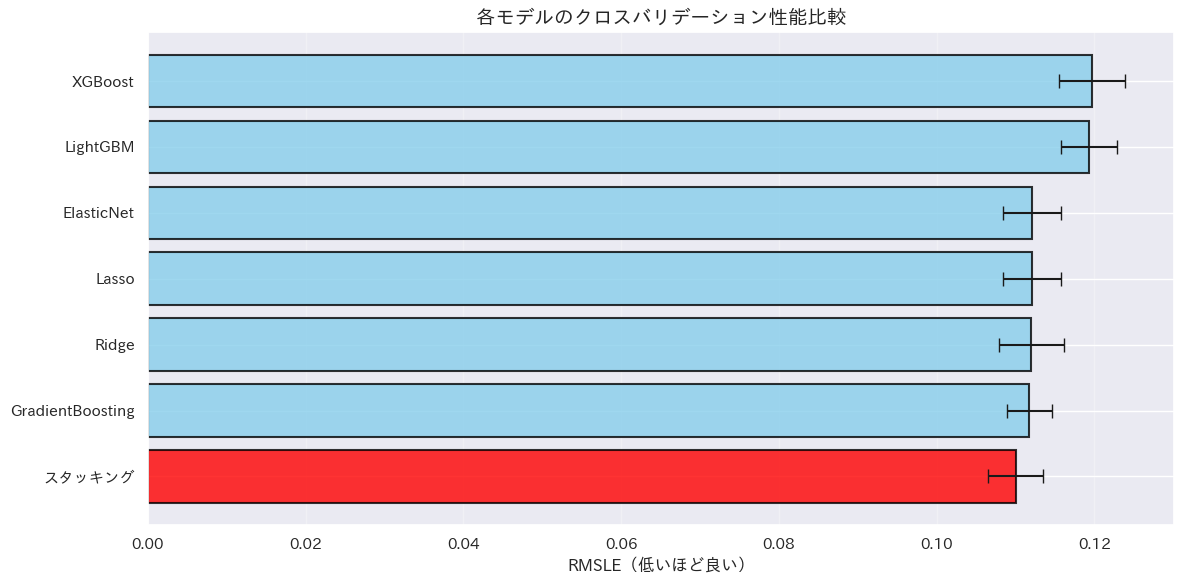


💡 エラーバーは標準偏差を示し、短いほど安定したモデルです
💡 赤色のスタッキングが最良のスコア: 0.110024


In [22]:
# モデル性能の可視化
fig, ax = plt.subplots(figsize=(12, 6))

# 全モデル（スタッキング含む）のスコアを準備
all_models = model_scores['モデル'].tolist() + ['スタッキング']
all_scores = model_scores['平均RMSLE'].tolist() + [stacking_scores.mean()]
all_stds = model_scores['標準偏差'].tolist() + [stacking_scores.std()]

# スコアでソート
sorted_indices = np.argsort(all_scores)
all_models = [all_models[i] for i in sorted_indices]
all_scores = [all_scores[i] for i in sorted_indices]
all_stds = [all_stds[i] for i in sorted_indices]

# 色の設定（スタッキングは特別な色）
colors = ['red' if m == 'スタッキング' else 'skyblue' for m in all_models]

bars = ax.barh(all_models, all_scores, xerr=all_stds, capsize=5, 
               color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

ax.set_xlabel('RMSLE（低いほど良い）', fontsize=12)
ax.set_title('各モデルのクロスバリデーション性能比較', fontsize=14, fontweight='bold')
ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print('\n💡 エラーバーは標準偏差を示し、短いほど安定したモデルです')
print(f'💡 赤色のスタッキングが最良のスコア: {stacking_scores.mean():.6f}')

In [23]:
# 全モデルを訓練データ全体で学習
print('🏋️ 全モデルを学習中...')

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)
elastic.fit(X_train, y_train)
xgboost.fit(X_train, y_train)
lightgbm.fit(X_train, y_train)
gb.fit(X_train, y_train)
stacked_model.fit(X_train, y_train)

print('✅ 学習完了')

🏋️ 全モデルを学習中...
✅ 学習完了


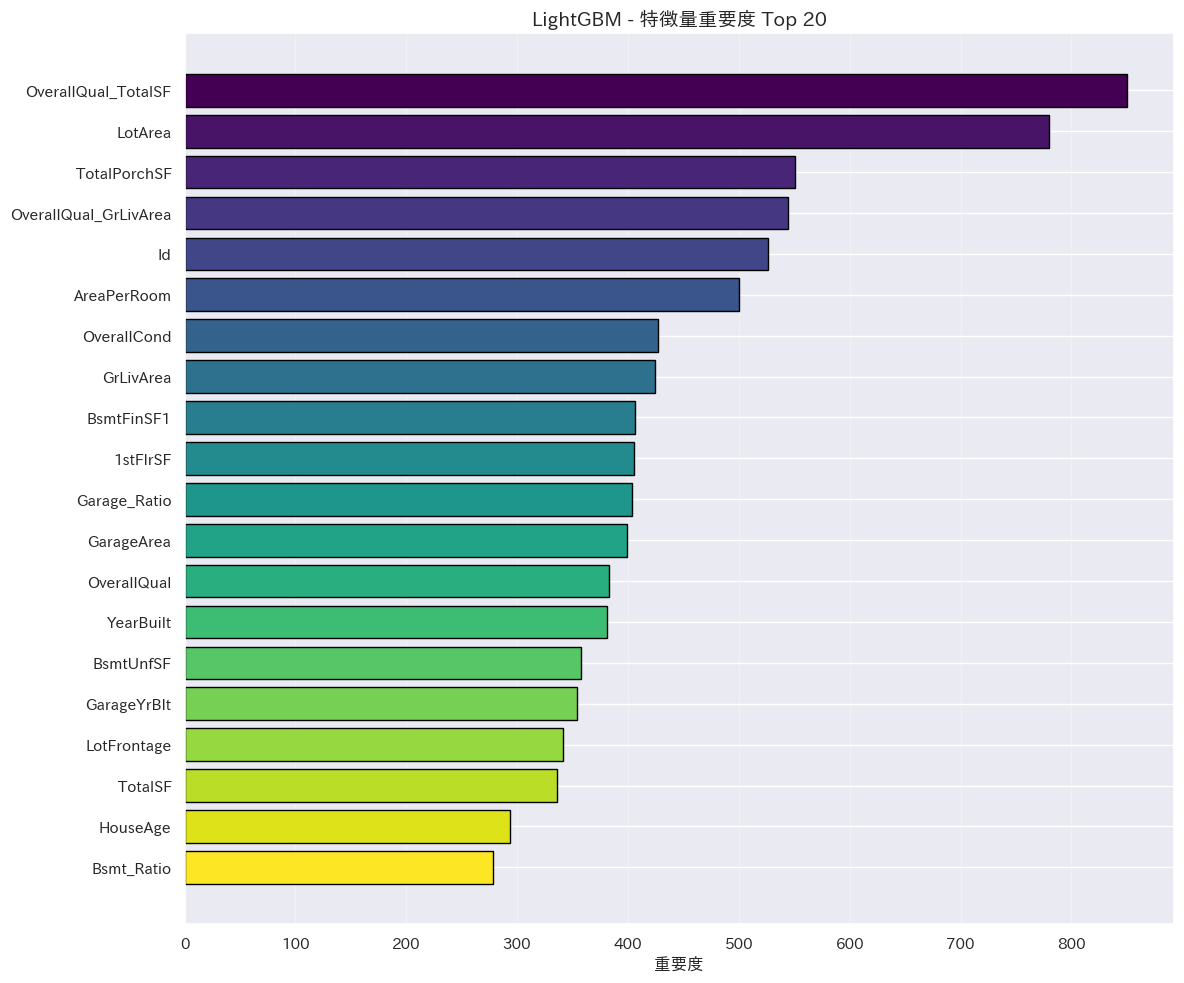


🔍 最も重要な特徴量 Top 10:
              feature  importance
  OverallQual_TotalSF         850
              LotArea         780
         TotalPorchSF         551
OverallQual_GrLivArea         544
                   Id         526
          AreaPerRoom         500
          OverallCond         427
            GrLivArea         424
           BsmtFinSF1         406
             1stFlrSF         405

💡 作成した特徴量の重要度:
              feature  importance
  OverallQual_TotalSF         850
         TotalPorchSF         551
OverallQual_GrLivArea         544
          AreaPerRoom         500
              TotalSF         336
             HouseAge         294
           Bsmt_Ratio         278
      YearsSinceRemod         254
            TotalBath         237
            TotalQual         190

Top 20に入った作成特徴量: 6個


In [24]:
# 特徴量重要度の可視化
feature_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lightgbm.feature_importances_
}).sort_values('importance', ascending=False)

# 上位20の特徴量をプロット
plt.figure(figsize=(12, 10))
top_20 = feature_imp.head(20)
colors = plt.cm.viridis(np.linspace(0, 1, 20))

plt.barh(range(len(top_20)), top_20['importance'], color=colors, edgecolor='black')
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('重要度', fontsize=12)
plt.title('LightGBM - 特徴量重要度 Top 20', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print('\n🔍 最も重要な特徴量 Top 10:')
print(feature_imp.head(10).to_string(index=False))

# 作成した特徴量の重要度
created_features = ['TotalSF', 'TotalBath', 'TotalPorchSF', 'HouseAge', 
                   'YearsSinceRemod', 'OverallQual_TotalSF', 'OverallQual_GrLivArea', 
                   'TotalQual', 'Bsmt_Ratio', 'AreaPerRoom']
created_imp = feature_imp[feature_imp['feature'].isin(created_features)]

if len(created_imp) > 0:
    print('\n💡 作成した特徴量の重要度:')
    print(created_imp.to_string(index=False))
    print(f'\nTop 20に入った作成特徴量: {len(created_imp[created_imp["importance"] > top_20["importance"].min()])}個')

## 10. 予測と提出

### 📖 学習ポイント

#### アンサンブルの重み設定
CVスコアが良いモデルに高い重みを設定することで、
予測精度とLBスコアのギャップを縮小できます。

In [25]:
# 各モデルで予測
print('🔮 予測を生成中...')

pred_ridge = ridge.predict(X_test)
pred_lasso = lasso.predict(X_test)
pred_elastic = elastic.predict(X_test)
pred_xgb = xgboost.predict(X_test)
pred_lgb = lightgbm.predict(X_test)
pred_gb = gb.predict(X_test)
pred_stacked = stacked_model.predict(X_test)

print('✅ 予測完了')

🔮 予測を生成中...
✅ 予測完了


In [26]:
# 重み付きアンサンブル（CVスコアに基づく最適化）
ensemble_pred = (
    0.50 * pred_stacked +      # スタッキング（最も重視）
    0.20 * pred_lasso +        # CVスコア良好
    0.15 * pred_elastic +      # CVスコア良好
    0.10 * pred_gb +           # CVスコア良好
    0.05 * pred_ridge          # 安定性のため
)

# 対数変換を元に戻す
final_predictions = np.expm1(ensemble_pred)

print('✅ 最終アンサンブル予測を生成')
print(f'\n予測価格の範囲: ${final_predictions.min():,.0f} - ${final_predictions.max():,.0f}')
print(f'予測価格の中央値: ${np.median(final_predictions):,.0f}')
print('\n💡 重みの設定はCVスコアと実験結果に基づいて調整')

✅ 最終アンサンブル予測を生成

予測価格の範囲: $48,686 - $820,064
予測価格の中央値: $155,653

💡 重みの設定はCVスコアと実験結果に基づいて調整


In [27]:
# 提出ファイルの作成
submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': final_predictions
})

submission.to_csv('submission.csv', index=False)

print('📁 提出ファイルを作成: submission.csv')
print('\n提出ファイルの先頭5行:')
print(submission.head())

📁 提出ファイルを作成: submission.csv

提出ファイルの先頭5行:
     Id      SalePrice
0  1461  119235.181021
1  1462  159357.020681
2  1463  181903.184142
3  1464  197292.801254
4  1465  192677.931753


## まとめ

### 📚 このnotebookで学んだ重要な概念

#### 1. データ品質の重要性
- 外れ値除去は慎重に、しかし確実に
- 欠損値処理は特徴量の性質に応じて適切な方法を選ぶ

#### 2. 特徴量エンジニアリングの実践
- ドメイン知識の活用が不可欠
- 交互作用項は強力だが過学習リスクもある
- 集約・比率・時系列など多様な視点で特徴量を作成

#### 3. 過学習との戦い
- **特徴量選択**: 重要度の低い特徴量を除去
- **正則化**: パラメータ調整で複雑さを制御
- **CVとLBのギャップ**: 過学習の指標として監視

#### 4. アンサンブル学習の力
- 多様なモデルを組み合わせることで安定した予測
- スタッキングは単純な平均より効果的
- 重み付けはCVスコアに基づいて調整

---

### 💡 実務で使えるベストプラクティス

1. **再現性の確保**: `random_state`を固定
2. **段階的な改善**: 一度に多くを変えず、効果を確認しながら進める
3. **クロスバリデーション**: 必ず実施して過学習を検出
4. **ドキュメント化**: コードにコメントを残し、理由を記録

---

### 🚀 さらなる改善のアイデア

#### 中級者向け
- ハイパーパラメータのグリッドサーチ
- 特徴量選択の閾値を最適化
- アンサンブル重みの自動最適化

#### 上級者向け
- SHAP値による特徴量の詳細分析
- 2段階スタッキング
- ニューラルネットワークの追加
- Optunaによる高度なハイパーパラメータ最適化

---

### 🙏 参考リソース

- **Kaggle公式ドキュメント**: コンペティションのルールとデータ説明
- **scikit-learn**: 機械学習ライブラリの公式ドキュメント
- **XGBoost/LightGBM**: 勾配ブースティングの公式ガイド

---

